# Wholesale customer segmentation



<h1><center><a id="1"></a> <br> Introduction</center></h1>

#### The data presented here represents the professional clients of a distributor. We have 440 observations and 8 

#### independent variables. 6 variables are continuous and represent sales of a particular type of products. 2 variables

#### are categorical - one for geographical location of the client and the other client´s channel type.

### **Variables**

#### 1. FRESH: annual spending (m.u.) on fresh products (Continuous)
#### 2. MILK: annual spending (m.u.) on milk products (Continuous)
#### 3. GROCERY: annual spending (m.u.)on grocery products (Continuous)
#### 4. FROZEN: annual spending (m.u.)on frozen products (Continuous)
#### 5. DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
#### 6. DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
#### 7. CHANNEL: customer Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) (Horeca 298 observations)
#### 8. REGION: customer Region: Lisbon, Oporto or Other (Nominal) (Lisbon, 77 observations, Oporto 47 , Other 316)


### Objective:

#### Clustering into groups of customers using ML for subsequent targeted marketing. 

#### We will employ KMeans algorithm and analyze the results with the help of PCA.

#### If the results won't be satisfying we will proceed to Agglomerative Clustering.

In [7]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from scipy.stats import boxcox, shapiro, probplot
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

<h1><center><a id="2"></a> <br> Data Preprocessing</center></h1>

Download the data

In [8]:
df=pd.read_csv(r"E:\ML-Projects\Clustering\8_wholesale_customer_segmentation\Wholesale customers data.csv")

In [9]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [10]:
#Checking for nulls

df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [11]:
#No nulls -great

#Checking for data types

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [12]:
#Statistical summary

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


We can clearly see that the data is not scaled and not normally distributed. We will examine thus further ahead.

In [13]:
#Let´s convert the categorical variables to meaningful data

df.Region.value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [14]:
df.Region=df.Region.map({3:'Other',2:'Lisbon',1:'Oporto'})

In [15]:
df.Channel.value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [16]:
df.Channel=df.Channel.map({1:'Horeca',2:'Retail'})

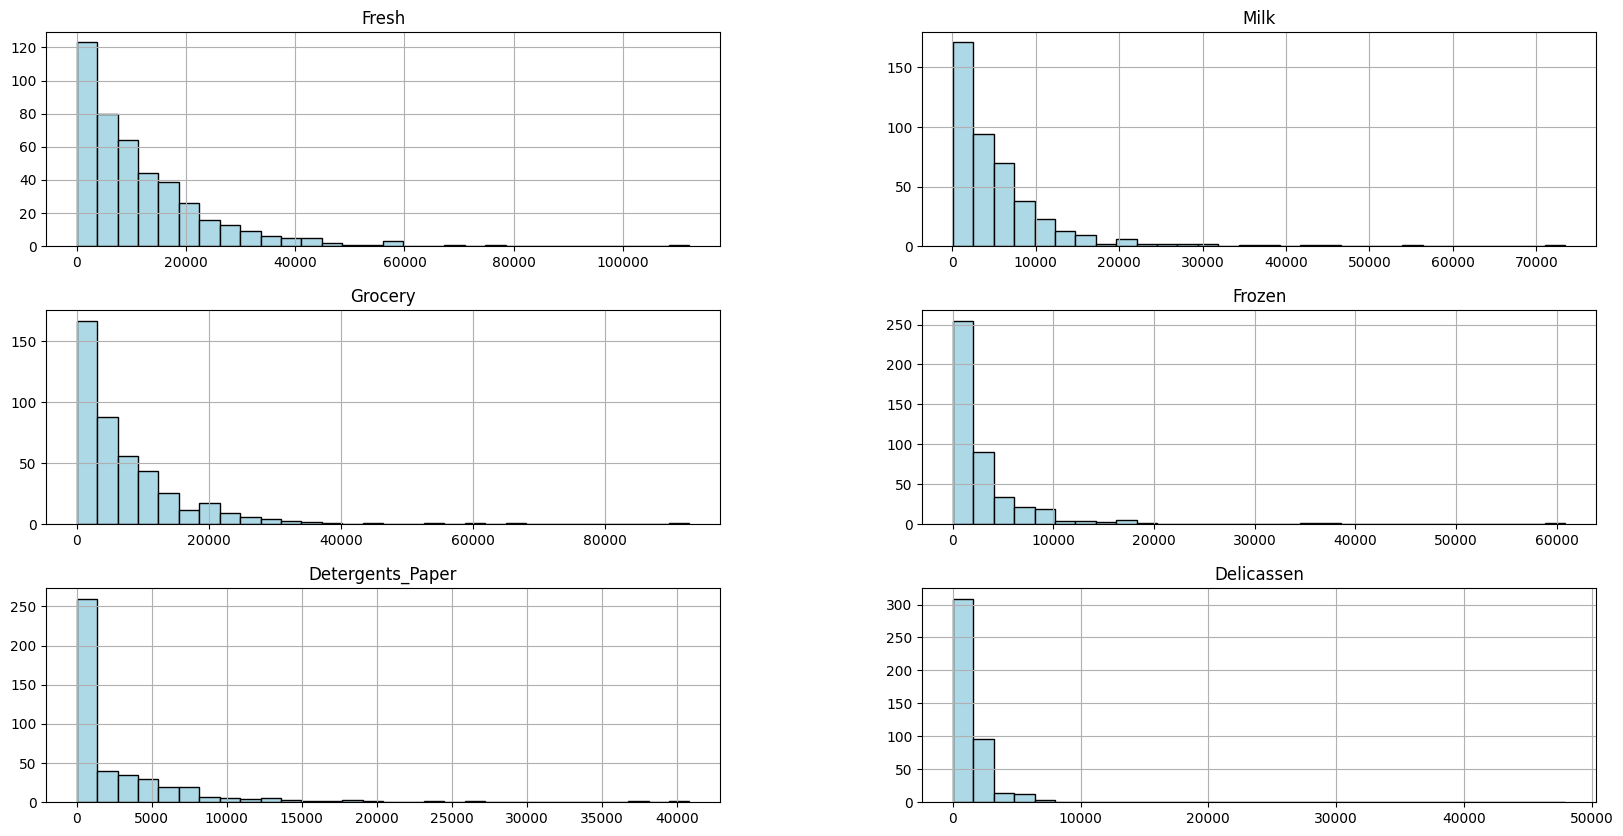

In [17]:
#Distribution of numeric variables

df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

The data appears to be very skewed and "rich" in outliers what can negatively affect our analysis since KMeans is susceptible to influential outlying values - they can strongly bias the centroids estimation. In a situation like this K-Medians might be advisable. However data might be transformed also. Here we will deploy the Box-Cox method. It can be implemented via ScikitLearn PowerTransformer() function or with the help of box-cox from Scipy Stats library. We will choose the second option.

In [18]:
data=df.copy()

lamb=[]
confidence=[]
for i in data.columns[2:]:
    data[i], coef, conf=boxcox(data[i]+0.0000001, alpha=0.05)   #We add a tiny constant as values need to be positive 
                                                                #for Box-Cox
    lamb.append(coef)
    confidence.append(conf)

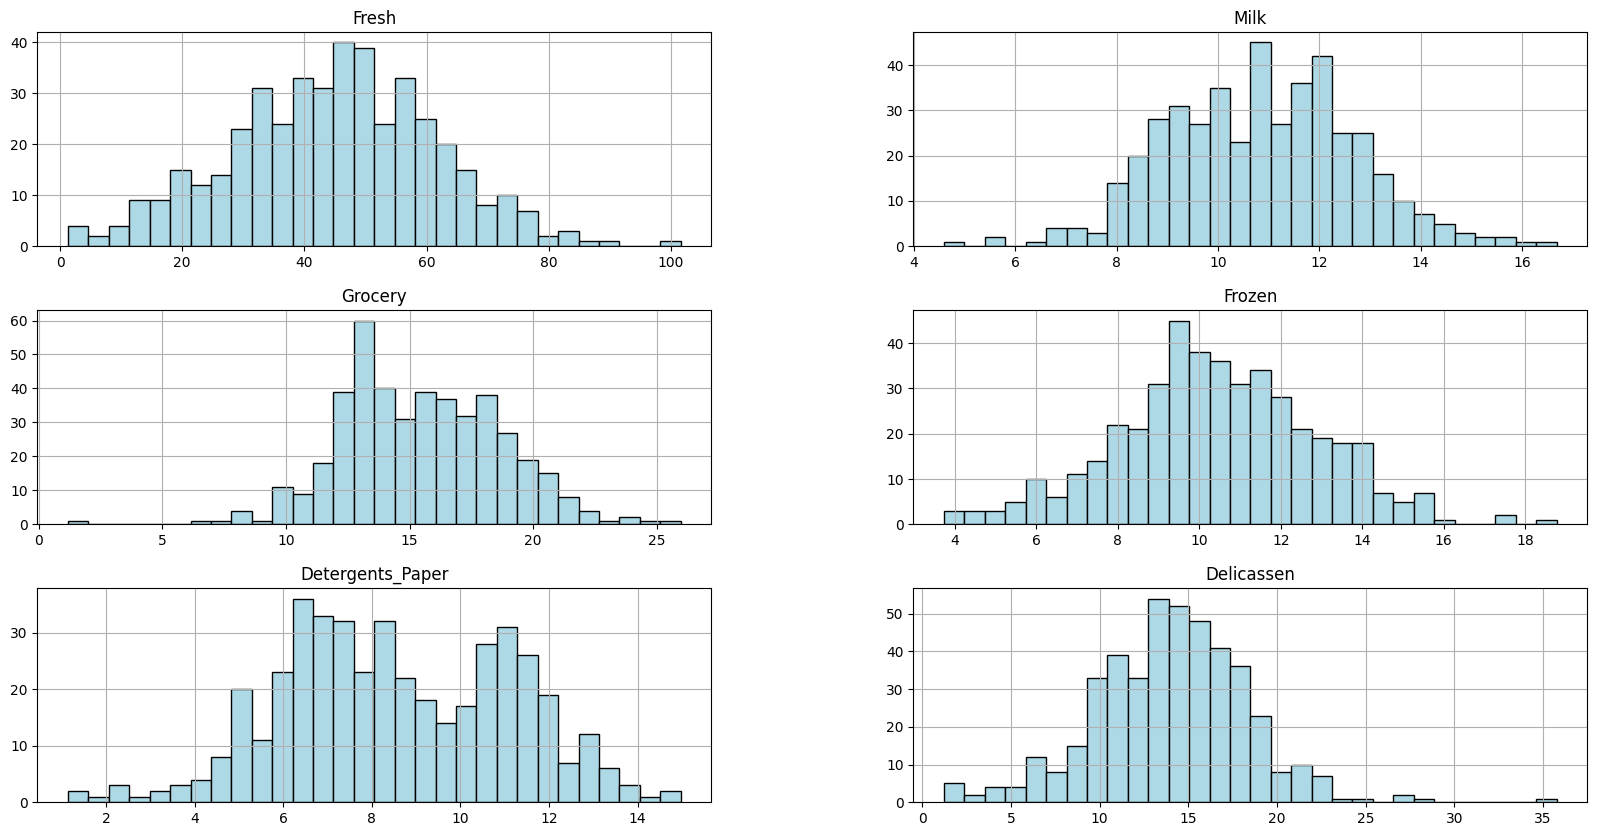

In [19]:
#Now the data resembles more the normal distribution

data.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

Also we need to scale the data so the distance analysis across dimensions won't be biased. KMeans performs the analysis on the same scale between variables and therefore unscaled data will lead to biased learning. For example if one variable is expressed in kilograms and another is in grams, Kmeans will consider 1000 grams as 1000 times higher than 1 kg as it considers only values and not units. We have to scale the data to same unit or "distance dimension"  

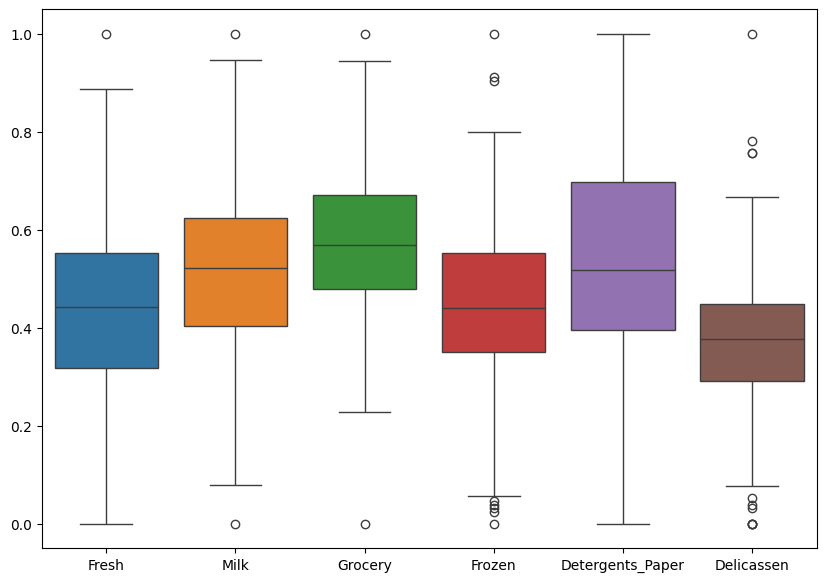

In [20]:
norm=data.iloc[:,2:] #Numerical data

scaler=MinMaxScaler()
columns=data.columns[2:]
norm=scaler.fit_transform(data.iloc[:,2:]) #Only numeric variables
norm=pd.DataFrame(norm, columns=columns)

plt.figure(figsize=(10,7))
sns.boxplot(data=norm)
plt.show()

As already mentioned influential outliers may negatively affect the calculation of cluster centers as individual outliers may have a lot of weight in determing cluster means. Therefore we will move the outliers to 1.5 of Interquartile range from 1st or 3rd quartile.

In [21]:
for i in norm.columns:
    iqr=np.percentile(norm[i], 75)-np.percentile(norm[i], 25)
    per75=np.percentile(norm[i], 75)
    per25=np.percentile(norm[i], 25)
    norm[i]=np.where(norm[i]>per75+1.5*iqr, per75+1.5*iqr,norm[i] )
    norm[i]=np.where(norm[i]<per25-1.5*iqr, per25-1.5*iqr,norm[i] )

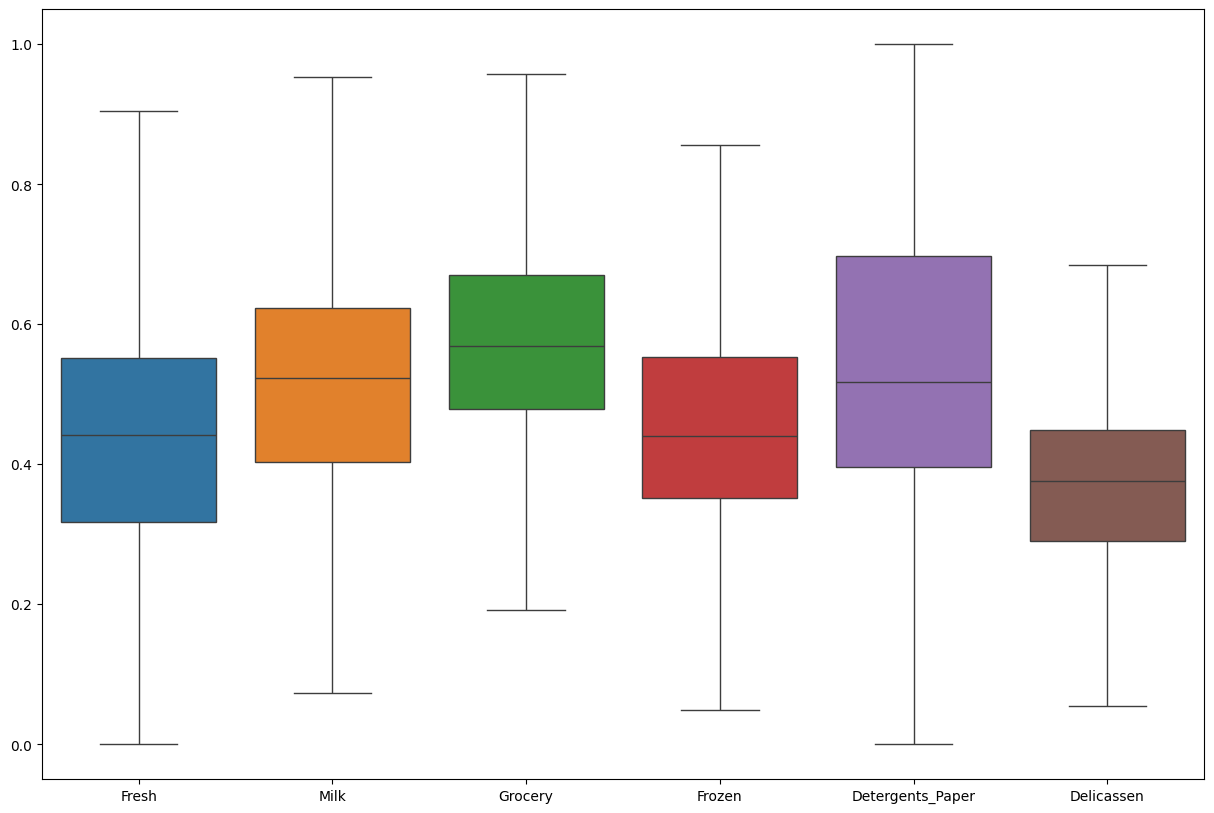

In [22]:
#Now we don´t have outliers

plt.figure(figsize=(15,10))
sns.boxplot(data=norm)
plt.show()

In [23]:
#Let´s also check for normality of the numeric variables now. However it is not a required assumptions 
#of KMeans but can produce better results. Shapiro Wilks test may be employed. 
#The null hypothesis is that the data is normal.



normality=pd.DataFrame(index=['p-value', 'test-statistic'])
for i in norm.columns:
    normality[i]=shapiro(norm[i])
    
normality.T    

,p-value,test-statistic
Fresh,0.997202,0.662730
Milk,0.996520,0.459561
Grocery,0.992466,0.025724
Frozen,0.995659,0.264255
Detergents_Paper,0.985208,0.000185
Delicassen,0.992554,0.027444


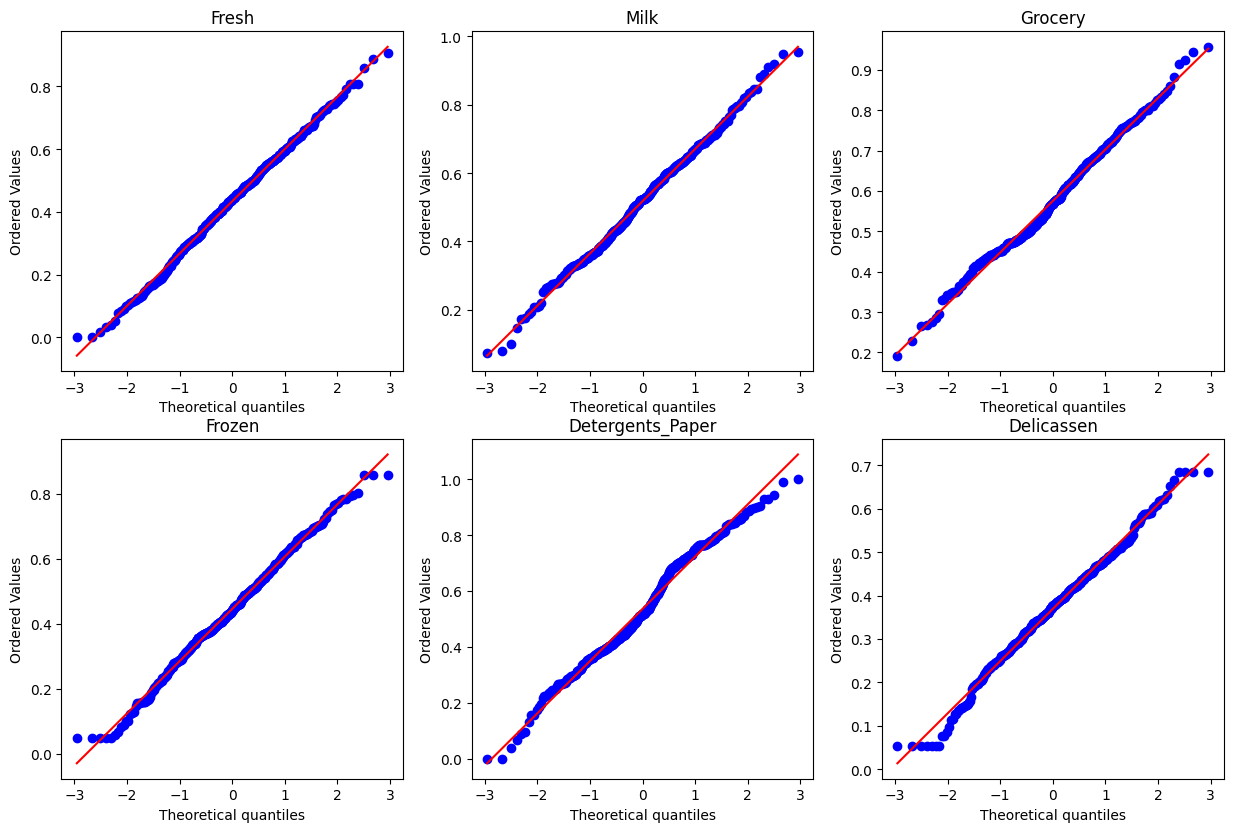

In [24]:
#We can also plot the normality via que quantile quantile plots from scipy statistical library.

plt.figure(figsize=(15,15))
for i,var in enumerate(norm.columns):
    plt.subplot(3,3,i+1)
    probplot(norm[var], plot=plt)
    plt.title(f'{var}')
plt.show()    

We can see that the data is not normally distributed. Additionally, we have two categorical variables, Region and Channel that have to be recoded (One Hot Encoding) for further analysis as not to cause incorrect distance estimations in distance/based algorithms. KMeans may be not stable while working on a mix of numerical and categorical data. How we define distance between the values in the Region variable? The right way in my opinion will be Hot Encoding

In [25]:
data=pd.get_dummies(data=df, columns= ['Region','Channel'], drop_first=True)

#Uniting our categorical dummified variables with numerical normalized data.

data.iloc[:,:6]=norm

<h1><center><a id="3"></a> <br>Modelling and Analysis</center></h1>

We are ready to perform the KMeans. However how many clusters should we choose? We have to determine the best number of clusters. This can be done using "elbow trick". We will calculate WSS - Within Sum 
of Squares (of the distances inside the cluster) for each option of number of clusters while the goal is find a number of clusters which minimizes considerably the WSS. We will examine WSS between 2 and 10 clusters. 

In [26]:
elbow_results=[]
for i in range(2,10):
    kmeans=KMeans(init='k-means++' , n_clusters=i, random_state=0)
    results=cross_validate(kmeans, data, cv=5)
    elbow_results.append(results['test_score'].mean()*-1)

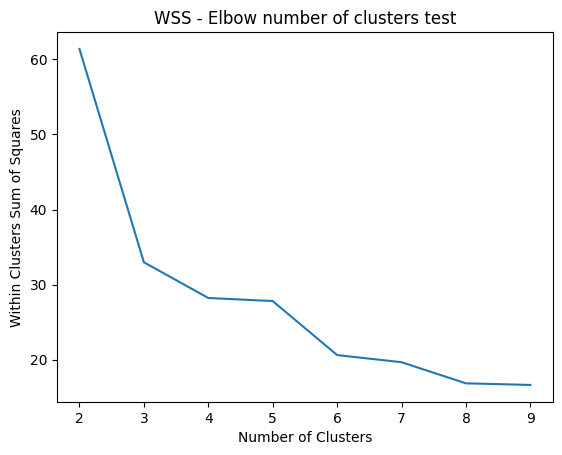

In [27]:

plt.plot(range(2,len(elbow_results)+2) , elbow_results)
plt.title('WSS - Elbow number of clusters test')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Clusters Sum of Squares')
plt.show()

Plotting the elbow we can see that it's formed at value 3 on the X-axis. It means that having 3 clusters will obtain the greatest proportional change in minimizing the WSS. However also number 6 presents a viable option as there is a considerable change in sum of distances between 5 and 6 clusters. Adding more clusters will lower the WSS but not at such considerable rate as the change between 2 and 3 clusters or between 5 or 6. Speaking in other words, we are looking for the smallest angle formed by the line on the plot. Now we will try to run the algorithm to group  3 clusters.

In [28]:
kmeans=KMeans(init='k-means++' , n_clusters=3, random_state=0)

cluster_model=kmeans.fit(data)


df['clusters']=cluster_model.predict(data).astype('str')

data['clusters']=df['clusters']

Let's visualize the clusters via pairs of variables. To do that more efficiently we need to reduce the dimensionality , so we will deploy PCA (Principal Components Analysis). First Let´s determine the best number of components to use in order to capture at least 90% of the variability of the data

In [29]:
pca=PCA(n_components=len(data.columns)-1)

pca.fit(data.iloc[:,:-1])

pca.explained_variance_ratio_

array([0.43475419, 0.3627994 , 0.06304534, 0.05522108, 0.0336834 ,
       0.02176789, 0.01480611, 0.00983244, 0.00409015])

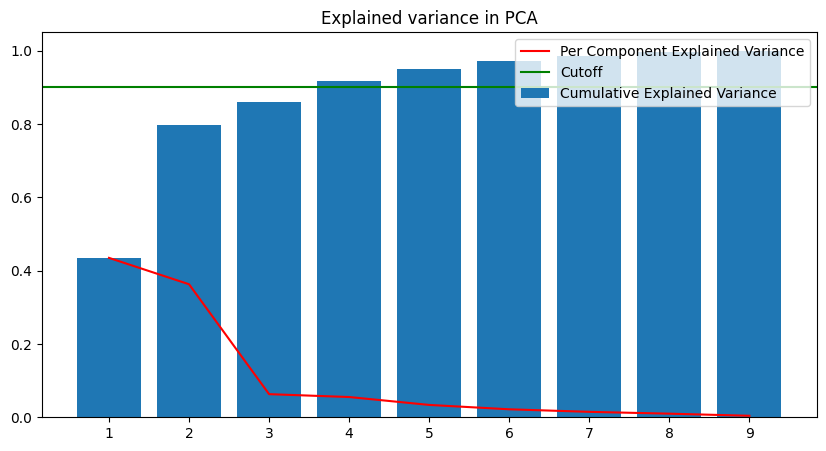

In [30]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10),pca.explained_variance_ratio_, c='red', label='Per Component Explained Variance')
plt.bar(range(1,10), height=np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance')
plt.axhline(y=0.9, c='g', label='Cutoff')
plt.title('Explained variance in PCA')
plt.xticks(range(1,10))
plt.legend(loc=1)
plt.show()

We can see that 90% of explained variability reached when we use 4 components. Therefore we will implement dimensionality reduction to 4 components

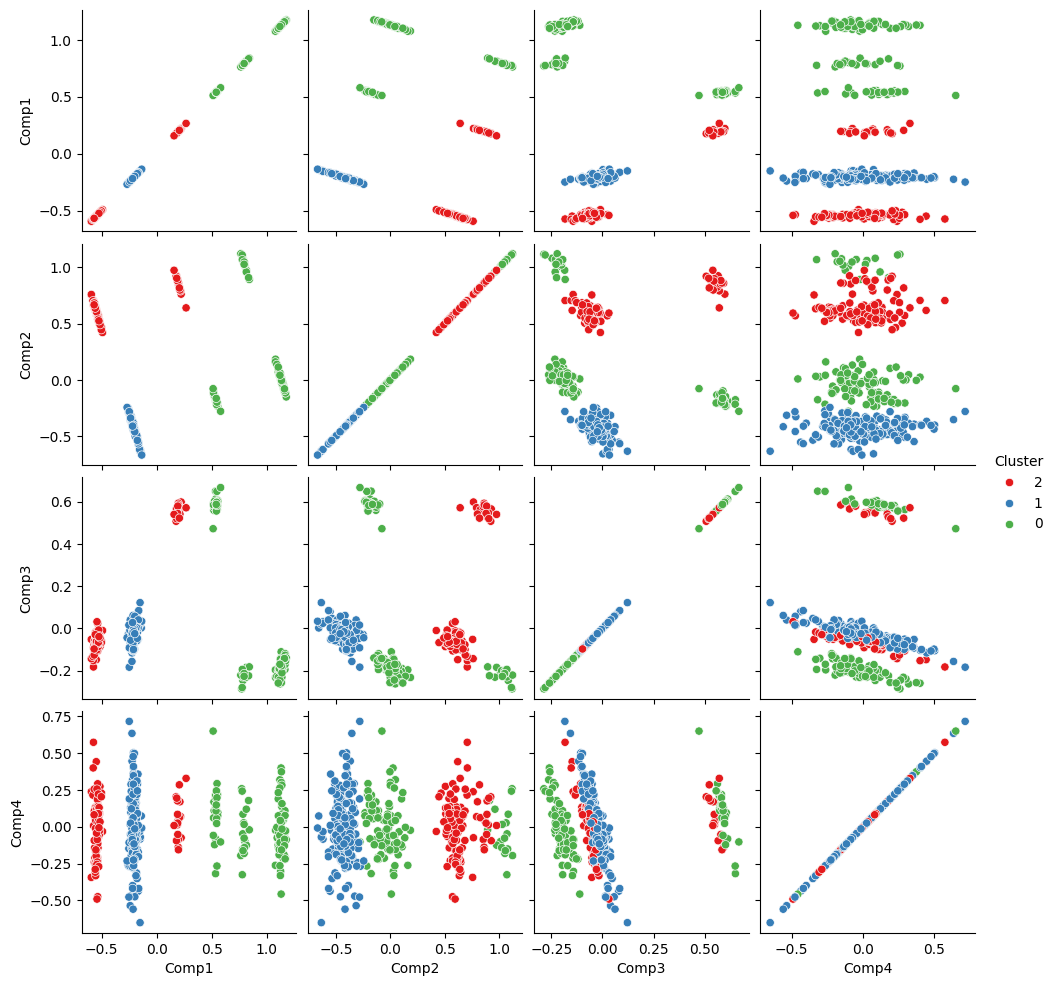

In [31]:
pca=PCA(n_components=4)
reduced=pca.fit_transform(data.iloc[:,:-1])

reduced=pd.DataFrame(np.column_stack([reduced, data.clusters]), columns=['Comp1','Comp2','Comp3','Comp4','Cluster'])

sns.pairplot(reduced, hue='Cluster', diag_kind=None, vars=reduced.columns[0:-1], palette='Set1')
plt.show()

It´s difficult to grasp the clusters like that. Let´s perform a component reduction to two variables.

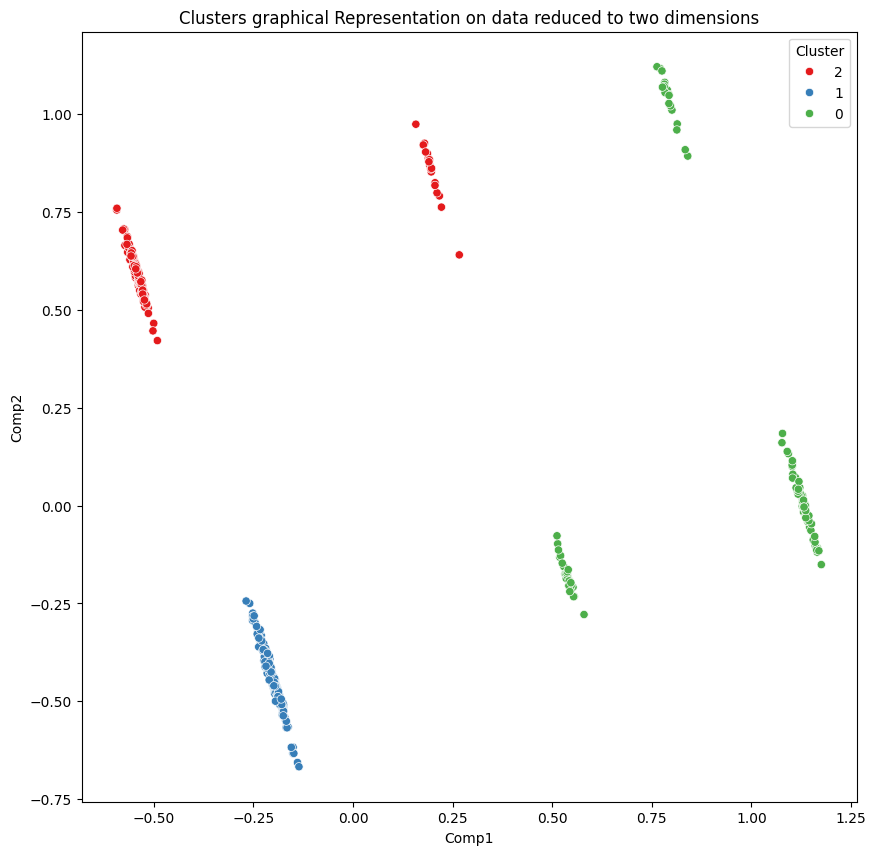

In [32]:
pca=PCA(n_components=2)
reduced=pca.fit_transform(data.iloc[:,:-1])
reduced=pd.DataFrame(np.column_stack([reduced, df.clusters]), columns=['Comp1','Comp2','Cluster'])

plt.figure(figsize=(10,10))
sns.scatterplot(data=reduced, hue='Cluster', x='Comp1',y='Comp2', palette='Set1')
plt.title('Clusters graphical Representation on data reduced to two dimensions',  fontsize=12)
plt.show()

Clearly the clusterization is not looking perfect on two dimensions . Since KMeans works good with spherical forms elongated cluster may present a problem for this centroid-based distance algorithm. It seems that choosing 6 clusters could provide better results.

Let´s see the means of the original  numerical variable values for different clusters now. 

<Figure size 1000x1000 with 0 Axes>

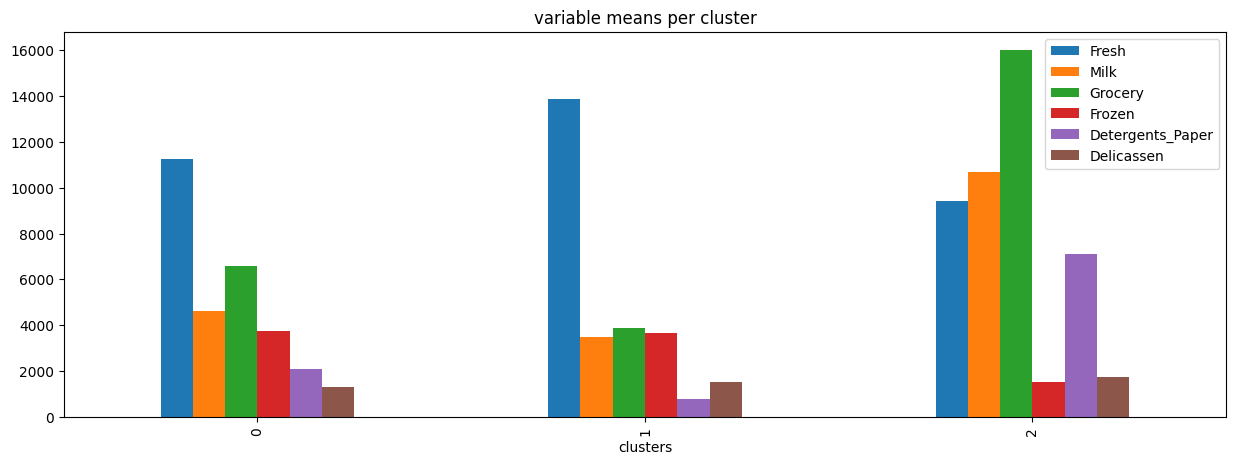

In [33]:
means=df.iloc[:,2:].groupby('clusters').mean()


plt.figure(figsize=(10,10))
means.groupby('clusters').mean().plot(kind='bar', figsize=(15,5))
plt.title('variable means per cluster')
plt.show()

Let's try to see what we can achieve with Hierarchical Clustering. For that we will use AgglomerativeClustering algorithm which creates a tree like hierarchy construction. As initial point it assumes that every data point is a cluster in itself and bit by bit it unites between every two data points based on the similarity between them (distance metric). The process is continued until all points are united or stopped if a distance threshold is defined (clusters are not merged above that point).  The advantage of this algorithm that it doesnt's suppose anything about the cluster form like K-Means which works good principally with spherical forms. Another plus is that we can visualize the clusterization process by using a dendrogram plot, a kind of tree.

In [34]:
hierarchy=AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward', compute_distances=True)

df['Hierarchical_clusters']=hierarchy.fit_predict(data)

Let´s plot 

In [35]:
reduced2=pd.DataFrame(np.column_stack([reduced, df['Hierarchical_clusters']]), columns=['Comp1','Comp2','Cluster_K_Means','Hierarchical_Clusters'])

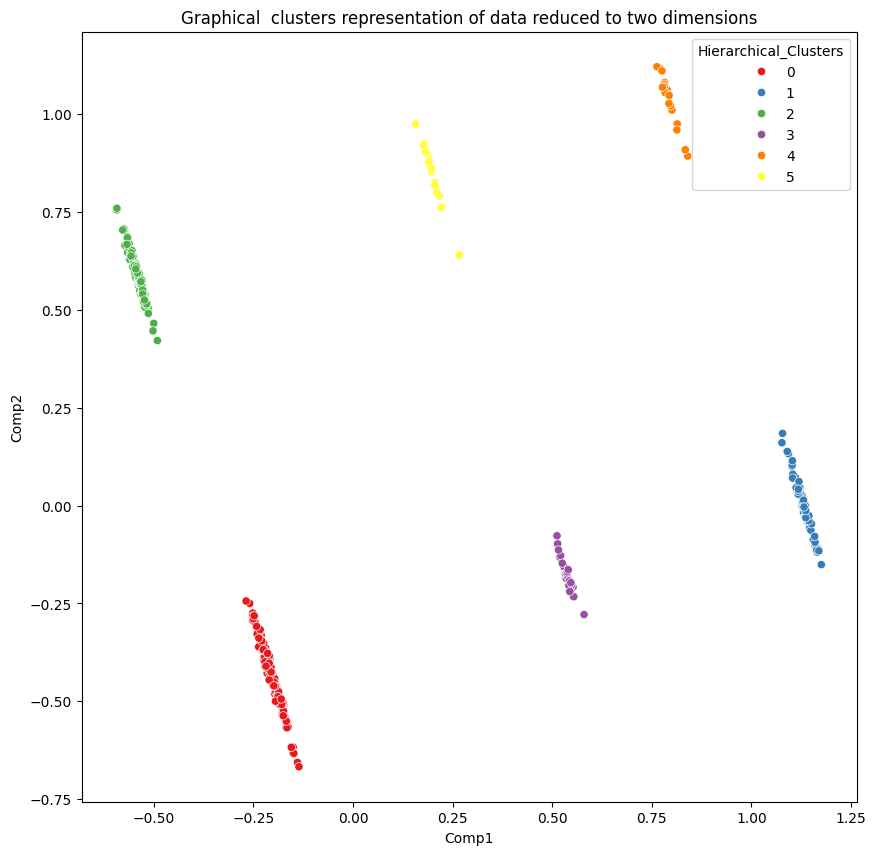

In [36]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=reduced2, hue='Hierarchical_Clusters', x='Comp1',y='Comp2', palette='Set1')
plt.title('Graphical  clusters representation of data reduced to two dimensions',  fontsize=12)
plt.show()

We can see that the clusters are now formed adequately. But what happens if we want to see what are options in forming clusters, or how the observations will be divided with more or less clusters? We can plot the dendrogram, even before running the Hierarchical clusterization algorithm that assigns the clusters. Python has the 'dendrogram' and 'linkage' functions available from scipy.cluster.hierarchy which we will use.

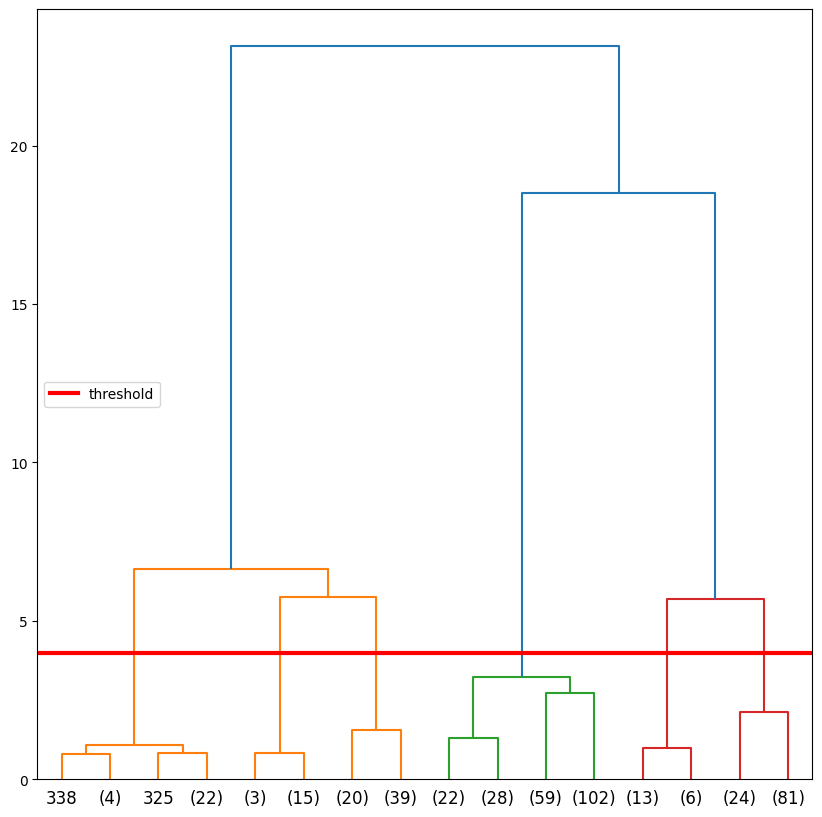

In [37]:


plt.figure(figsize=(10,10))
dendrogram(linkage(data ,method='ward'), truncate_mode='level', p=3 )
plt.axhline(y=4, label='threshold', color='red', lw=3)
plt.title='Dendrogram'
plt.legend(loc=6)
plt.show()

To understand the dendrogram i added the red line which depicts a situation when we want 6 clusters, exactly what we received with the algorithm we ran. Pay attention that there are 6 vertical lines crossing the horizontal red line. These vertical lines denote the 6 clusters formed. The numbers in parenthesis are numbers of observations.You can see that some clusters are not subdivided on the plot we see (since i limited the subdivisions shown to a depth of 3 for better understanding) but of course they have hidden subdivisions. Therefore we have clusters that have 59,28,19,18 observations. Two additional clusters have further subdivisions on the view - so to calculate their number of observations we have to sum (22+28+59+102) and (65+9+3+11+11+34+5+31). We can compare these results to cluster counts as following: 

In [38]:
#Number of observations per Cluster
print(reduced2.Hierarchical_Clusters.value_counts())

Hierarchical_Clusters
0    211
2    105
1     59
3     28
5     19
4     18
Name: count, dtype: int64


This notebook presented two clustering solutions while using dimensionality reduction to depict the results. Clustering can be used in business environment for discovering patterns, segmentation for marketing and CRM reasons and more.